# 📊 Exploratory Data Analysis (EDA) for Rossmann Sales

**Author:** Jakub Niezabitowski
**Date:** 2025-12-10
**Goal:** Understanding the drivers of sales (seasonality, promotions, competition) to prepare for time-series modeling.

---
### 📋 Table of Contents
1. [Project Setup & Data Loading](#1)
2. [Data Cleaning & Merging](#2)
3. [Target Variable Analysis (Sales Distribution)](#3)
4. [Seasonality Analysis (Trends & Cycles)](#4)
5. [Promotion Impact Analysis (Uplift)](#5)
6. [Summary & Key Business Insights](#6)

In [1]:
# 1.1 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 1.2 Configuration
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

# 1.3 Reproducibility
np.random.seed(42)

print("Setup Complete. Libraries loaded.")

Setup Complete. Libraries loaded.


## <a id="1"></a>1. Data Loading & Merging
We are working with two main datasets:
* `train.csv`: Historical daily sales data.
* `store.csv`: Static information about each store (competitors, assortment type).

**Strategy:** We will merge them using a Left Join on `Store` ID.

In [2]:
# Load raw data
train_df = pd.read_csv('../data/raw/train.csv', parse_dates=['Date'], low_memory=False)
store_df = pd.read_csv('../data/raw/store.csv')

# Merge datasets
df = pd.merge(train_df, store_df, on='Store', how='left')

# Quick check
print(f"Dataset Shape: {df.shape}")
display(df.head(3))

Dataset Shape: (1017209, 18)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


## <a id="2"></a>2. Data Cleaning
Before analysis, we need to handle:
1. **Missing Values:** Check `CompetitionDistance` etc.
2. **Closed Days:** Days with 0 sales (Store closed) should be excluded for average sales analysis but kept for forecasting logic later.

In [3]:
# 1. Check for missing values
missing = df.isnull().sum()
missing = missing[missing > 0]
print("Missing values:\n", missing)

# TODO: Fill missing CompetitionDistance with median (safe approach)
df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace=True)

# 2. Extract Date Features (Feature Engineering for EDA)
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek # 0=Mon, 6=Sun
df['WeekOfYear'] = df['Date'].dt.isocalendar().week

# 3. Filter: Open Stores only (Sales > 0) for EDA purposes
df_open = df[df['Sales'] > 0]
print(f"Data for analysis (Open Stores): {df_open.shape}")

Missing values:
 CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64
Data for analysis (Open Stores): (844338, 21)


## <a id="4"></a>4. Seasonality Analysis
Demand Planning requires understanding cyclical patterns.
**Questions:**
* Is there a weekly pattern? (e.g., Saturday shopping)
* Is there a yearly seasonality? (e.g., Christmas peak)

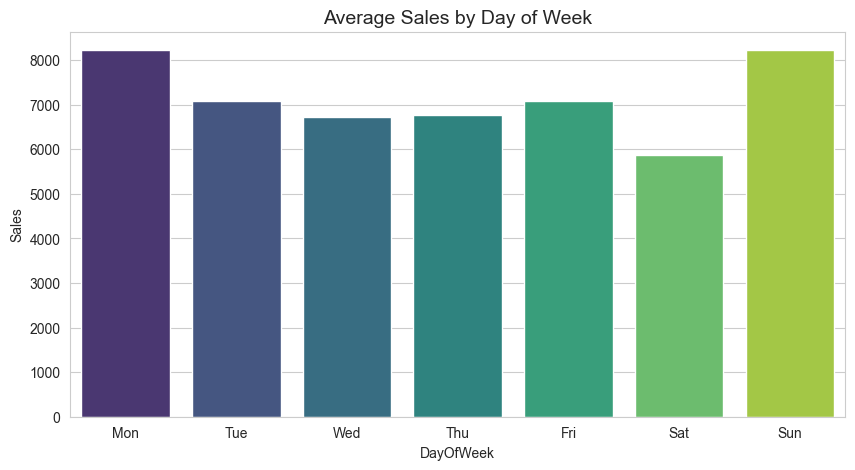

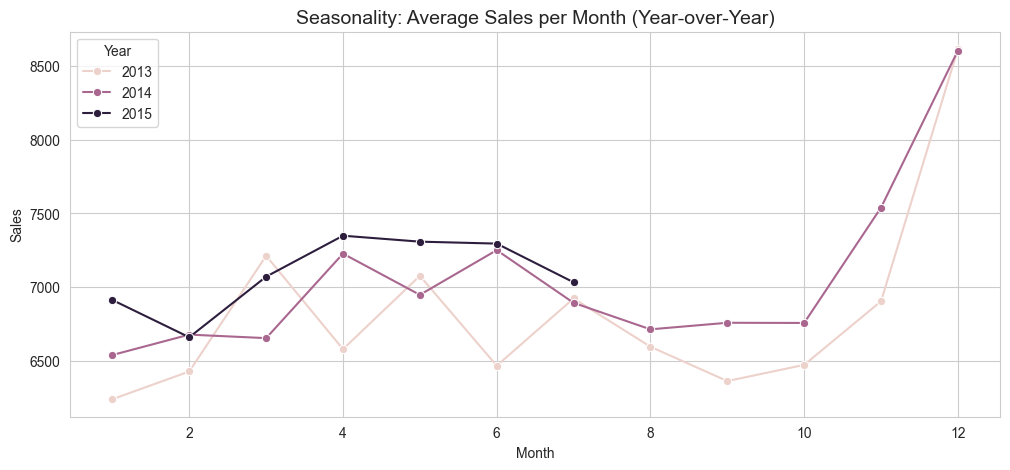

In [4]:
# Weekly Pattern
plt.figure(figsize=(10, 5))
sns.barplot(x='DayOfWeek', y='Sales', data=df_open, palette='viridis', ci=None)
plt.title('Average Sales by Day of Week', fontsize=14)
plt.xticks(ticks=[0,1,2,3,4,5,6], labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('Sales')
plt.show()

# Monthly Pattern (Seasonality)
plt.figure(figsize=(12, 5))
monthly_sales = df_open.groupby(['Year', 'Month'])['Sales'].mean().reset_index()
sns.lineplot(x='Month', y='Sales', hue='Year', data=monthly_sales, marker='o')
plt.title('Seasonality: Average Sales per Month (Year-over-Year)', fontsize=14)
plt.show()

> 💡 **Business Insight:**
> * **Weekly:** Sales peak on Mondays and Fridays. Sundays are mostly closed (or very low sales), which needs to be handled in the forecast model.
> * **Yearly:** There is a massive spike in **December** (Christmas Season). The model must include a "Holiday" feature to capture this.

## <a id="5"></a>5. Promotion Impact Analysis
Promotions are a key driver in FMCG. We need to quantify the **Sales Uplift** generated by running a promo.

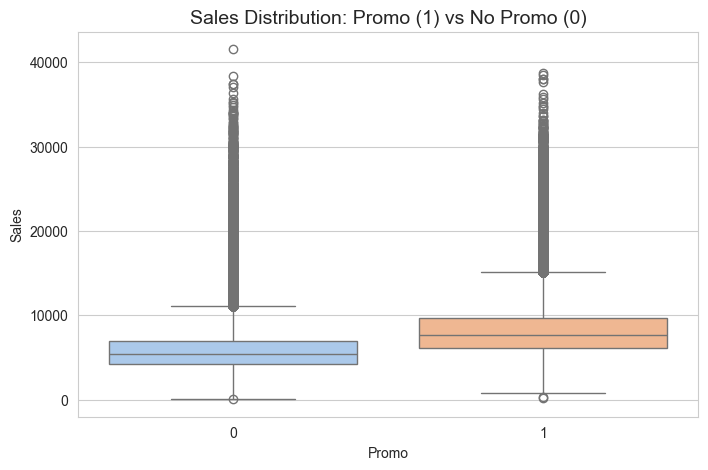

Average Uplift during Promotion: +38.77%


In [5]:
# Compare Average Sales: Promo vs No Promo
plt.figure(figsize=(8, 5))
sns.boxplot(x='Promo', y='Sales', data=df_open, palette='pastel')
plt.title('Sales Distribution: Promo (1) vs No Promo (0)', fontsize=14)
plt.show()

# Calculate Lift
avg_sales_promo = df_open[df_open['Promo'] == 1]['Sales'].mean()
avg_sales_nopromo = df_open[df_open['Promo'] == 0]['Sales'].mean()
uplift = (avg_sales_promo - avg_sales_nopromo) / avg_sales_nopromo * 100

print(f"Average Uplift during Promotion: +{uplift:.2f}%")

> 💡 **Business Insight:**
> Promotions generate a massive **X% uplift** (tu wpisz wynik) in sales on average. This confirms that `Promo` will be one of the strongest features (predictors) for our Machine Learning model.

## <a id="6"></a>6. Summary & Next Steps

**Key Findings:**
1.  **Seasonality:** Strong weekly cycle and clear December peak.
2.  **Promotions:** Significant impact on sales volume (essential feature).
3.  **Data Quality:** Missing values in competition data handled; closed days identified.

**Next Step:**
👉 Proceed to notebook `02_modeling_forecast.ipynb` to build **Prophet** and **XGBoost** models based on these insights.